In [1]:
import networkx as nx
from copy import deepcopy
import pandas as pd
from heapq import heappush,heappop
from itertools import count
import numpy as np
import matplotlib.pyplot as plt

1. 数据导入以及预处理

In [2]:

G=nx.Graph()
nodes=pd.read_csv("E:\\运筹学\\选题三\\nodes.csv")
nodename=nodes['nodename']
nodeno=nodes['nodeId']
name2no={}
for i in range(len(nodename)):
    name2no[nodename[i]]=nodeno[i]
    G.add_node(nodeno[i])

edgesfile=open("E:\\运筹学\\选题三\\adjacencymatrix.csv")
lines=edgesfile.readlines()
i=0
k=0
adjlist=[[]]
edge2no={}
for line in lines:
    i+=1
    adjlist.append([])
    line=line.split(',')
    #print(line)
    for j in range(len(line)):
        if line[j]=='1' or line[j]=='1\n':
            G.add_edge(i,j+1)
            adjlist[i].append(j+1)
            if (min(i,j+1),max(i,j+1)) not in edge2no.keys():
                edge2no[(min(i,j+1),max(i,j+1))]=k
                k+=1
print(edge2no)
X=np.array([0.0]*56)
weights=pd.read_csv("E:\\运筹学\\选题三\\links.csv")
startnode=weights['startnode']
endnode=weights['endnode']
linkdelay=weights['linkdelay']
for i in range(len(startnode)):
    G[startnode[i]][endnode[i]]['weight']=linkdelay[i]
    index=edge2no[(min(startnode[i],endnode[i]),max(startnode[i],endnode[i]))]
    X[index]=linkdelay[i]
print(X)

{(1, 2): 0, (1, 3): 1, (1, 7): 2, (1, 8): 3, (2, 7): 4, (3, 4): 5, (3, 7): 6, (3, 10): 7, (3, 16): 8, (3, 17): 9, (3, 18): 10, (3, 21): 11, (3, 22): 12, (4, 7): 13, (4, 9): 14, (4, 10): 15, (5, 6): 16, (5, 8): 17, (6, 8): 18, (6, 9): 19, (6, 10): 20, (6, 14): 21, (6, 15): 22, (7, 8): 23, (9, 10): 24, (9, 14): 25, (10, 14): 26, (10, 17): 27, (10, 23): 28, (11, 12): 29, (11, 14): 30, (11, 15): 31, (12, 13): 32, (12, 14): 33, (12, 15): 34, (13, 14): 35, (13, 25): 36, (14, 16): 37, (14, 17): 38, (14, 18): 39, (14, 23): 40, (16, 17): 41, (16, 18): 42, (16, 22): 43, (17, 18): 44, (18, 19): 45, (18, 20): 46, (18, 21): 47, (18, 22): 48, (18, 23): 49, (19, 22): 50, (20, 21): 51, (22, 23): 52, (23, 24): 53, (23, 25): 54, (24, 25): 55}
[276.025077   679.7026769  655.098004   162.6117352  118.9976816
 498.364052   959.7439585  340.3857267  585.267751   223.8119395
 751.2670593  255.0951155  505.9570517  959.2914252  699.0767227
 890.9032525  547.21553    138.6244428  149.2940056  257.5082541
 840.

2. 计算betweenness centrality

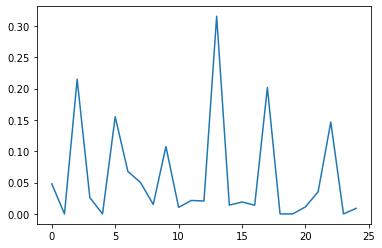

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [3]:

cb = nx.betweenness_centrality(G)
cb = sorted(cb.items(), key=lambda item:item[0], reverse = False)
name=[]
score=[]
for (u,v) in cb:
    name.append(u)
    score.append(v)
plt.plot(score)
plt.show()
print(name)

3. 计算Degree centrality

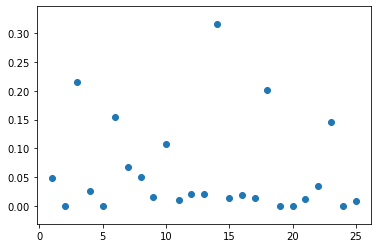

In [4]:
cd=nx.degree(G)
name=[]
score=[]
for (u,v) in cb:
    name.append(u)
    score.append(v)
plt.scatter(name,score)

4. KSP算法实现

In [5]:
def get_path_length(G,path):
    length=0
    if len(path)>1:
        for i in range(len(path)-1):
            try:
                u=path[i]
                v=path[i+1]
                length+=G[u][v]['weight']
            except KeyError:
                print((u,v),'weighterror')
    return length

In [6]:
def ksp(G,source,target,K=1):
    try:
        length,path=nx.single_source_dijkstra(G,source,target)
    except nx.NetworkXNoPath:
        print("no path\n")
        return ([],[[]])
    
    A=[path]
    A_cost=[length]
    B=[]
    B_cost=[]
    used_edge=set()
    for i in range(len(path)-1):
        used_edge.add((path[i],path[i+1]))
    for k in range(K-1):
        rootpath=A[-1]
        for i in range(len(A[-1])-1):
            removed_nodes=[]
            removed_edges=[]
            stray_node=A[-1][i]
            for j in range(i):
                removed_nodes.append(A[-1][j])
            #print("removed nodes",removed_nodes)
            for node in removed_nodes:
                adjlist=list(G.adj[node])
                for adjnode in adjlist:
                    if G.has_edge(node,adjnode):
                        removed_edges.append((node,adjnode,G[node][adjnode]['weight']))
                        G.remove_edge(node,adjnode)
            for (u,v) in used_edge:
                if G.has_edge(u,v) and u==stray_node:
                    removed_edges.append((u,v,G[u][v]['weight']))
                    G.remove_edge(u,v)
            try:
                length,path=nx.single_source_dijkstra(G,stray_node,target)
            except nx.NetworkXNoPath:
                for (u,v,w) in removed_edges:
                    G.add_edge(u,v)
                    G[u][v]['weight']=w
                continue
            for (u,v,w) in removed_edges:
                G.add_edge(u,v)
                G[u][v]['weight']=w
            #print("stray path",path)
            newpath=A[-1][:i]+path
            #print("contracate path",newpath)
            if newpath not in B:
                B.append(newpath)
                B_cost.append(get_path_length(G,newpath))
        if len(B)==0:
            print("only have %d path"%(len(A)))
            break
        candidateno=B_cost.index(min(B_cost))
        if B[candidateno] not in A:
            candidatepath=B[candidateno]
            A.append(candidatepath)
            A_cost.append(get_path_length(G,candidatepath))
            for i in range(len(candidatepath)-1):
                used_edge.add((candidatepath[i],candidatepath[i+1]))
            print("candidate path",B[candidateno])
            B.pop(candidateno)
            B_cost.pop(candidateno)
    return A_cost,A

5. 五组实验

In [7]:
def probe(A,Y,rank,covered_edge,costlist,pathlist):
    for j in range(len(pathlist)):
        edgelist=[]
        path=pathlist[j]
        for i in range(len(path)-1):
            u=path[i]
            v=path[i+1]
            edgelist.append(edge2no[(min(u,v),max(u,v))])
            covered_edge.add(edge2no[(min(u,v),max(u,v))])
        A[rank][edgelist]=1
        if np.linalg.matrix_rank(A) > rank:
            Y[rank]=costlist[j]
            rank+=1
        else:
            A[rank]=0
        if rank==56:
            break
    print("rank:",rank)
    uncovered=[]
    for i in range(0,55):
        if i not in covered_edge:
            uncovered.append(i)
    print("uncovered",uncovered)
    return A,Y,rank,covered_edge

In [6]:

# 第一组实验 monitor1
# SNFN - PHLA
A=np.zeros((56,56))
Y=np.array([0.0]*56)
rank=0
covered_edge=set()
costlist,pathlist=ksp(G,7,18,150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)


candidate path [7, 8, 6, 14, 23, 18]
candidate path [7, 8, 6, 14, 18]
candidate path [7, 8, 6, 14, 23, 22, 19, 18]
candidate path [7, 2, 1, 8, 6, 14, 23, 22, 18]
candidate path [7, 8, 6, 9, 14, 23, 22, 18]
candidate path [7, 3, 22, 18]
candidate path [7, 8, 5, 6, 14, 23, 22, 18]
candidate path [7, 2, 1, 3, 22, 18]
candidate path [7, 8, 1, 3, 22, 18]
candidate path [7, 8, 6, 14, 17, 16, 18]
candidate path [7, 1, 8, 6, 14, 23, 22, 18]
candidate path [7, 8, 6, 14, 10, 17, 16, 18]
candidate path [7, 3, 21, 18]
candidate path [7, 8, 6, 14, 10, 3, 22, 18]
candidate path [7, 3, 18]
candidate path [7, 2, 1, 8, 6, 9, 14, 23, 22, 18]
candidate path [7, 3, 17, 16, 18]
candidate path [7, 8, 6, 14, 17, 3, 22, 18]
candidate path [7, 8, 6, 14, 10, 23, 22, 18]
candidate path [7, 2, 1, 3, 21, 18]
candidate path [7, 8, 1, 3, 21, 18]
candidate path [7, 8, 6, 10, 14, 23, 22, 18]
candidate path [7, 8, 6, 14, 10, 17, 3, 22, 18]
candidate path [7, 8, 6, 14, 17, 16, 22, 18]
candidate path [7, 3, 10, 14, 23, 2

In [7]:
# 第一组实验 monitor2
# CHCG - SNAN
costlist,pathlist=ksp(G,3,13,200)
print(len(pathlist))
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [3, 17, 14, 13]
candidate path [3, 17, 10, 14, 13]
candidate path [3, 10, 14, 23, 25, 13]
candidate path [3, 17, 14, 23, 25, 13]
candidate path [3, 17, 10, 14, 23, 25, 13]
candidate path [3, 22, 23, 14, 13]
candidate path [3, 10, 14, 12, 13]
candidate path [3, 22, 18, 23, 14, 13]
candidate path [3, 10, 14, 23, 24, 25, 13]
candidate path [3, 10, 17, 14, 13]
candidate path [3, 17, 14, 12, 13]
candidate path [3, 17, 14, 23, 24, 25, 13]
candidate path [3, 16, 17, 14, 13]
candidate path [3, 17, 16, 14, 13]
candidate path [3, 10, 23, 14, 13]
candidate path [3, 17, 10, 14, 12, 13]
candidate path [3, 17, 10, 14, 23, 24, 25, 13]
candidate path [3, 22, 18, 14, 13]
candidate path [3, 21, 18, 22, 23, 14, 13]
candidate path [3, 22, 23, 24, 25, 13]
candidate path [3, 18, 22, 23, 14, 13]
candidate path [3, 17, 10, 23, 14, 13]
candidate path [3, 22, 18, 23, 24, 25, 13]
candidate path [3, 10, 14, 11, 12, 13]
candidate path [3, 17, 16, 18, 22, 23, 14, 13]
candidate path [3, 22, 19, 18, 23

rank: 49
uncovered []


In [14]:
def draw_residual(X_pred):
    residual=np.abs(X-X_pred)
    plt.figure()
    plt.subplot(211)
    plt.plot(residual)
    i=list(range(56))
    plt.subplot(212)
    plt.scatter(i,residual)
    plt.show()

In [15]:
def draw_epsilon(X_pred):
    epsilon=np.abs(X-X_pred)/X
    plt.plot(epsilon)
    l1=np.sum(epsilon<0.2)
    l2=np.sum(epsilon >= 0.2 )
    l3=np.sum(epsilon >= 0.4 )
    l4=np.sum(epsilon >= 0.6 )
    l5=np.sum(epsilon >= 0.8 )
    l6=np.sum(epsilon >= 1.0 )
    l2=l2-l3
    l3=l3-l4
    l4=l4-l5
    l5=l5-l6
    size=[l1,l2,l3,l4,l5,l6]
    print(size)
    labels=['<0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1.0','>1.0']
    plt.pie(size,labels=labels)
    plt.show()

In [35]:
# 第二组实验 monitor1
# STTL-ORLD
A=np.zeros((56,56))
Y=np.array([0.0]*56)
rank=0
covered_edge=set()
costlist,pathlist=ksp(G,15,21,150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [15, 6, 14, 17, 3, 21]
candidate path [15, 6, 14, 23, 22, 18, 21]
candidate path [15, 6, 14, 23, 18, 21]
candidate path [15, 11, 14, 10, 3, 21]
candidate path [15, 6, 14, 10, 17, 3, 21]
candidate path [15, 6, 8, 1, 3, 21]
candidate path [15, 6, 14, 18, 21]
candidate path [15, 11, 14, 10, 17, 3, 21]
candidate path [15, 6, 9, 14, 10, 3, 21]
candidate path [15, 6, 14, 23, 22, 3, 21]
candidate path [15, 6, 14, 23, 22, 19, 18, 21]
candidate path [15, 11, 14, 18, 21]
candidate path [15, 6, 10, 3, 21]
candidate path [15, 6, 14, 23, 18, 22, 3, 21]
candidate path [15, 12, 14, 10, 3, 21]
candidate path [15, 6, 14, 17, 10, 3, 21]
candidate path [15, 6, 14, 17, 16, 3, 21]
candidate path [15, 6, 14, 16, 17, 3, 21]
candidate path [15, 6, 14, 23, 10, 3, 21]
candidate path [15, 6, 14, 18, 22, 3, 21]
candidate path [15, 6, 14, 10, 17, 16, 3, 21]
candidate path [15, 6, 8, 7, 3, 21]
candidate path [15, 11, 14, 16, 17, 3, 21]
candidate path [15, 6, 14, 23, 22, 18, 3, 21]
candidate path [15,

In [36]:
# 第二组实验 monitor2
# NY54-LA03
costlist,pathlist=ksp(G,1,23,150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [1, 8, 6, 9, 14, 23]
candidate path [1, 2, 7, 8, 6, 14, 23]
candidate path [1, 8, 5, 6, 14, 23]
candidate path [1, 3, 10, 14, 23]
candidate path [1, 3, 17, 14, 23]
candidate path [1, 7, 8, 6, 14, 23]
candidate path [1, 8, 6, 14, 10, 23]
candidate path [1, 8, 6, 10, 14, 23]
candidate path [1, 3, 17, 10, 14, 23]
candidate path [1, 8, 6, 14, 18, 22, 23]
candidate path [1, 8, 6, 14, 18, 23]
candidate path [1, 3, 22, 23]
candidate path [1, 3, 22, 18, 23]
candidate path [1, 3, 10, 23]
candidate path [1, 2, 7, 8, 5, 6, 14, 23]
candidate path [1, 3, 21, 18, 22, 23]
candidate path [1, 3, 10, 17, 14, 23]
candidate path [1, 8, 6, 9, 14, 10, 23]
candidate path [1, 8, 6, 14, 18, 19, 22, 23]
candidate path [1, 3, 18, 22, 23]
candidate path [1, 8, 6, 9, 10, 14, 23]
candidate path [1, 3, 16, 17, 14, 23]
candidate path [1, 3, 17, 16, 14, 23]
candidate path [1, 3, 17, 16, 18, 22, 23]
candidate path [1, 8, 6, 14, 17, 10, 23]
candidate path [1, 3, 22, 19, 18, 23]
candidate path [1, 3, 22, 1

In [52]:
# 第三组实验 monitor1
# RLGH - SNDG
A=np.zeros((56,56))
Y=np.array([0.0]*56)
rank=0
covered_edge=set()
costlist,pathlist=ksp(G,5,24,150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [5, 6, 14, 23, 24]
candidate path [5, 8, 6, 14, 23, 25, 24]
candidate path [5, 8, 6, 9, 14, 23, 24]
candidate path [5, 6, 14, 23, 25, 24]
candidate path [5, 6, 9, 14, 23, 24]
candidate path [5, 8, 6, 14, 13, 25, 24]
candidate path [5, 8, 6, 14, 10, 23, 24]
candidate path [5, 8, 6, 10, 14, 23, 24]
candidate path [5, 8, 6, 14, 18, 22, 23, 24]
candidate path [5, 8, 6, 14, 18, 23, 24]
candidate path [5, 6, 14, 13, 25, 24]
candidate path [5, 8, 1, 3, 10, 14, 23, 24]
candidate path [5, 6, 10, 14, 23, 24]
candidate path [5, 8, 1, 3, 17, 14, 23, 24]
candidate path [5, 8, 6, 9, 14, 13, 25, 24]
candidate path [5, 8, 6, 14, 12, 13, 25, 24]
candidate path [5, 8, 6, 14, 18, 19, 22, 23, 24]
candidate path [5, 8, 1, 3, 17, 10, 14, 23, 24]
candidate path [5, 8, 6, 9, 10, 14, 23, 24]
candidate path [5, 8, 6, 14, 17, 10, 23, 24]
candidate path [5, 8, 1, 3, 22, 23, 24]
candidate path [5, 8, 6, 14, 17, 16, 18, 22, 23, 24]
candidate path [5, 8, 1, 3, 22, 18, 23, 24]
candidate path [5, 8, 6, 

In [53]:
# 第三组实验 monitor2
# PTLD - LA03 
costlist,pathlist=ksp(G,20,23,150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [20, 18, 23]
candidate path [20, 18, 19, 22, 23]
candidate path [20, 18, 14, 23]
candidate path [20, 21, 18, 22, 23]
candidate path [20, 18, 16, 17, 14, 23]
candidate path [20, 21, 3, 10, 14, 23]
candidate path [20, 18, 16, 17, 10, 14, 23]
candidate path [20, 18, 22, 3, 10, 14, 23]
candidate path [20, 21, 3, 17, 14, 23]
candidate path [20, 18, 22, 3, 17, 14, 23]
candidate path [20, 21, 3, 22, 23]
candidate path [20, 18, 22, 16, 17, 14, 23]
candidate path [20, 21, 3, 22, 18, 23]
candidate path [20, 18, 21, 3, 10, 14, 23]
candidate path [20, 18, 16, 14, 23]
candidate path [20, 18, 3, 10, 14, 23]
candidate path [20, 18, 14, 10, 23]
candidate path [20, 18, 17, 14, 23]
candidate path [20, 18, 19, 22, 3, 10, 14, 23]
candidate path [20, 18, 16, 17, 3, 10, 14, 23]
candidate path [20, 21, 3, 10, 23]
candidate path [20, 18, 16, 17, 10, 23]
candidate path [20, 18, 22, 3, 10, 23]
candidate path [20, 21, 3, 10, 17, 14, 23]
candidate path [20, 21, 3, 18, 22, 23]
candidate path [20, 18

In [61]:
# 第四组实验 monitor1
# CHCG - SNFN
A=np.zeros((56,56))
Y=np.array([0.0]*56)
rank=0
covered_edge=set()
costlist,pathlist=ksp(G,name2no['CHCG'],name2no['SNFN'],150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [3, 21, 18]
candidate path [3, 18]
candidate path [3, 22, 19, 18]
candidate path [3, 17, 16, 18]
candidate path [3, 10, 14, 23, 22, 18]
candidate path [3, 10, 14, 23, 18]
candidate path [3, 17, 14, 23, 22, 18]
candidate path [3, 17, 16, 22, 18]
candidate path [3, 17, 10, 14, 23, 22, 18]
candidate path [3, 10, 14, 18]
candidate path [3, 16, 18]
candidate path [3, 22, 23, 18]
candidate path [3, 17, 18]
candidate path [3, 17, 14, 18]
candidate path [3, 10, 17, 16, 18]
candidate path [3, 17, 10, 14, 18]
candidate path [3, 10, 23, 22, 18]
candidate path [3, 17, 10, 23, 22, 18]
candidate path [3, 16, 17, 14, 23, 22, 18]
candidate path [3, 17, 16, 14, 23, 22, 18]
candidate path [3, 22, 23, 14, 18]
candidate path [3, 10, 14, 17, 16, 18]
candidate path [3, 10, 23, 14, 18]
candidate path [3, 21, 20, 18]
candidate path [3, 1, 8, 6, 14, 23, 22, 18]
candidate path [3, 17, 16, 22, 23, 18]
candidate path [3, 17, 10, 23, 14, 18]
candidate path [3, 16, 14, 23, 22, 18]
candidate path [3, 

In [62]:
# 第四组实验 monitor2
# DLLS ATLN
costlist,pathlist=ksp(G,name2no['DLLS'],name2no['ATLN'],150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [14, 9, 6]
candidate path [14, 10, 6]
candidate path [14, 10, 9, 6]
candidate path [14, 17, 10, 6]
candidate path [14, 10, 3, 1, 8, 6]
candidate path [14, 23, 10, 6]
candidate path [14, 17, 3, 1, 8, 6]
candidate path [14, 10, 17, 3, 1, 8, 6]
candidate path [14, 17, 3, 10, 6]
candidate path [14, 23, 22, 3, 1, 8, 6]
candidate path [14, 10, 3, 7, 8, 6]
candidate path [14, 16, 17, 10, 6]
candidate path [14, 23, 18, 22, 3, 1, 8, 6]
candidate path [14, 17, 3, 7, 8, 6]
candidate path [14, 17, 10, 3, 1, 8, 6]
candidate path [14, 10, 3, 4, 9, 6]
candidate path [14, 11, 15, 6]
candidate path [14, 10, 3, 1, 2, 7, 8, 6]
candidate path [14, 17, 16, 3, 1, 8, 6]
candidate path [14, 10, 17, 3, 7, 8, 6]
candidate path [14, 10, 4, 9, 6]
candidate path [14, 17, 3, 4, 9, 6]
candidate path [14, 10, 3, 1, 8, 5, 6]
candidate path [14, 17, 3, 1, 2, 7, 8, 6]
candidate path [14, 23, 22, 18, 16, 17, 10, 6]
candidate path [14, 18, 22, 3, 1, 8, 6]
candidate path [14, 10, 17, 16, 3, 1, 8, 6]
candidat

In [71]:
# 第五组实验 monitor1
# DLLS - CHCG
A=np.zeros((56,56))
Y=np.array([0.0]*56)
rank=0
covered_edge=set()
costlist,pathlist=ksp(G,name2no['DLLS'],name2no['CHCG'],150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [14, 17, 3]
candidate path [14, 10, 17, 3]
candidate path [14, 23, 22, 3]
candidate path [14, 23, 18, 22, 3]
candidate path [14, 17, 10, 3]
candidate path [14, 17, 16, 3]
candidate path [14, 16, 17, 3]
candidate path [14, 23, 10, 3]
candidate path [14, 18, 22, 3]
candidate path [14, 10, 17, 16, 3]
candidate path [14, 23, 22, 18, 21, 3]
candidate path [14, 23, 18, 21, 3]
candidate path [14, 23, 22, 18, 3]
candidate path [14, 23, 18, 3]
candidate path [14, 23, 22, 18, 16, 17, 3]
candidate path [14, 23, 18, 19, 22, 3]
candidate path [14, 6, 8, 1, 3]
candidate path [14, 18, 21, 3]
candidate path [14, 23, 22, 19, 18, 21, 3]
candidate path [14, 6, 10, 3]
candidate path [14, 23, 22, 16, 17, 3]
candidate path [14, 23, 18, 22, 16, 17, 3]
candidate path [14, 17, 16, 18, 22, 3]
candidate path [14, 9, 4, 3]
candidate path [14, 10, 17, 16, 18, 22, 3]
candidate path [14, 23, 22, 18, 17, 3]
candidate path [14, 23, 18, 17, 3]
candidate path [14, 10, 4, 3]
candidate path [14, 9, 6, 8, 1,

In [72]:
# 第五次实验 monitor2
# SNFN- LA03
costlist,pathlist=ksp(G,name2no['SNFN'],name2no['LA03'],200)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [18, 23]
candidate path [18, 19, 22, 23]
candidate path [18, 14, 23]
candidate path [18, 16, 17, 14, 23]
candidate path [18, 16, 17, 10, 14, 23]
candidate path [18, 22, 3, 10, 14, 23]
candidate path [18, 22, 3, 17, 14, 23]
candidate path [18, 22, 16, 17, 14, 23]
candidate path [18, 21, 3, 10, 14, 23]
candidate path [18, 16, 14, 23]
candidate path [18, 3, 10, 14, 23]
candidate path [18, 14, 10, 23]
candidate path [18, 17, 14, 23]
candidate path [18, 19, 22, 3, 10, 14, 23]
candidate path [18, 16, 17, 3, 10, 14, 23]
candidate path [18, 16, 17, 10, 23]
candidate path [18, 22, 3, 10, 23]
candidate path [18, 21, 3, 22, 23]
candidate path [18, 22, 3, 10, 17, 14, 23]
candidate path [18, 3, 22, 23]
candidate path [18, 22, 3, 16, 17, 14, 23]
candidate path [18, 22, 16, 14, 23]
candidate path [18, 16, 22, 23]
candidate path [18, 22, 3, 17, 16, 14, 23]
candidate path [18, 16, 17, 3, 22, 23]
candidate path [18, 21, 3, 10, 23]
candidate path [18, 22, 16, 17, 3, 10, 14, 23]
candidate p

candidate path [18, 22, 3, 1, 8, 6, 9, 14, 13, 25, 23]
candidate path [18, 22, 3, 7, 8, 6, 14, 13, 25, 23]
candidate path [18, 22, 3, 10, 6, 15, 11, 14, 23]
candidate path [18, 16, 17, 10, 9, 4, 3, 22, 23]
candidate path [18, 21, 3, 1, 8, 6, 15, 11, 14, 23]
candidate path [18, 3, 1, 8, 6, 15, 11, 14, 23]
candidate path [18, 16, 17, 10, 9, 6, 8, 1, 3, 22, 23]
rank: 49
uncovered []


In [8]:
# 第六组实验 monitor1
# DLLS - CHCG
A=np.zeros((56,56))
Y=np.array([0.0]*56)
rank=0
covered_edge=set()
costlist,pathlist=ksp(G,name2no['DLLS'],name2no['CHCG'],150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [14, 17, 3]
candidate path [14, 10, 17, 3]
candidate path [14, 23, 22, 3]
candidate path [14, 23, 18, 22, 3]
candidate path [14, 17, 10, 3]
candidate path [14, 17, 16, 3]
candidate path [14, 16, 17, 3]
candidate path [14, 23, 10, 3]
candidate path [14, 18, 22, 3]
candidate path [14, 10, 17, 16, 3]
candidate path [14, 23, 22, 18, 21, 3]
candidate path [14, 23, 18, 21, 3]
candidate path [14, 23, 22, 18, 3]
candidate path [14, 23, 18, 3]
candidate path [14, 23, 22, 18, 16, 17, 3]
candidate path [14, 23, 18, 19, 22, 3]
candidate path [14, 6, 8, 1, 3]
candidate path [14, 18, 21, 3]
candidate path [14, 23, 22, 19, 18, 21, 3]
candidate path [14, 6, 10, 3]
candidate path [14, 23, 22, 16, 17, 3]
candidate path [14, 23, 18, 22, 16, 17, 3]
candidate path [14, 17, 16, 18, 22, 3]
candidate path [14, 9, 4, 3]
candidate path [14, 10, 17, 16, 18, 22, 3]
candidate path [14, 23, 22, 18, 17, 3]
candidate path [14, 23, 18, 17, 3]
candidate path [14, 10, 4, 3]
candidate path [14, 9, 6, 8, 1,

In [9]:
# 第六次实验 monitor2
# SNFN- LA03
costlist,pathlist=ksp(G,name2no['SNFN'],name2no['LA03'],200)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [18, 23]
candidate path [18, 19, 22, 23]
candidate path [18, 14, 23]
candidate path [18, 16, 17, 14, 23]
candidate path [18, 16, 17, 10, 14, 23]
candidate path [18, 22, 3, 10, 14, 23]
candidate path [18, 22, 3, 17, 14, 23]
candidate path [18, 22, 16, 17, 14, 23]
candidate path [18, 21, 3, 10, 14, 23]
candidate path [18, 16, 14, 23]
candidate path [18, 3, 10, 14, 23]
candidate path [18, 14, 10, 23]
candidate path [18, 17, 14, 23]
candidate path [18, 19, 22, 3, 10, 14, 23]
candidate path [18, 16, 17, 3, 10, 14, 23]
candidate path [18, 16, 17, 10, 23]
candidate path [18, 22, 3, 10, 23]
candidate path [18, 21, 3, 22, 23]
candidate path [18, 22, 3, 10, 17, 14, 23]
candidate path [18, 3, 22, 23]
candidate path [18, 22, 3, 16, 17, 14, 23]
candidate path [18, 22, 16, 14, 23]
candidate path [18, 16, 22, 23]
candidate path [18, 22, 3, 17, 16, 14, 23]
candidate path [18, 16, 17, 3, 22, 23]
candidate path [18, 21, 3, 10, 23]
candidate path [18, 22, 16, 17, 3, 10, 14, 23]
candidate p

candidate path [18, 22, 3, 1, 8, 6, 9, 14, 13, 25, 23]
candidate path [18, 22, 3, 7, 8, 6, 14, 13, 25, 23]
candidate path [18, 22, 3, 10, 6, 15, 11, 14, 23]
candidate path [18, 16, 17, 10, 9, 4, 3, 22, 23]
candidate path [18, 21, 3, 1, 8, 6, 15, 11, 14, 23]
candidate path [18, 3, 1, 8, 6, 15, 11, 14, 23]
candidate path [18, 16, 17, 10, 9, 6, 8, 1, 3, 22, 23]
rank: 49
uncovered []


In [10]:
#第六组实验 monitor3
# RLGH - SNDG
costlist,pathlist=ksp(G,5,24,150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [5, 6, 14, 23, 24]
candidate path [5, 8, 6, 14, 23, 25, 24]
candidate path [5, 8, 6, 9, 14, 23, 24]
candidate path [5, 6, 14, 23, 25, 24]
candidate path [5, 6, 9, 14, 23, 24]
candidate path [5, 8, 6, 14, 13, 25, 24]
candidate path [5, 8, 6, 14, 10, 23, 24]
candidate path [5, 8, 6, 10, 14, 23, 24]
candidate path [5, 8, 6, 14, 18, 22, 23, 24]
candidate path [5, 8, 6, 14, 18, 23, 24]
candidate path [5, 6, 14, 13, 25, 24]
candidate path [5, 8, 1, 3, 10, 14, 23, 24]
candidate path [5, 6, 10, 14, 23, 24]
candidate path [5, 8, 1, 3, 17, 14, 23, 24]
candidate path [5, 8, 6, 9, 14, 13, 25, 24]
candidate path [5, 8, 6, 14, 12, 13, 25, 24]
candidate path [5, 8, 6, 14, 18, 19, 22, 23, 24]
candidate path [5, 8, 1, 3, 17, 10, 14, 23, 24]
candidate path [5, 8, 6, 9, 10, 14, 23, 24]
candidate path [5, 8, 6, 14, 17, 10, 23, 24]
candidate path [5, 8, 1, 3, 22, 23, 24]
candidate path [5, 8, 6, 14, 17, 16, 18, 22, 23, 24]
candidate path [5, 8, 1, 3, 22, 18, 23, 24]
candidate path [5, 8, 6, 

In [11]:
#第六组实验 monitor4
# PTLD - LA03 
costlist,pathlist=ksp(G,20,23,150)
A,Y,rank,covered_edge=probe(A,Y,rank,covered_edge,costlist,pathlist)

candidate path [20, 18, 23]
candidate path [20, 18, 19, 22, 23]
candidate path [20, 18, 14, 23]
candidate path [20, 21, 18, 22, 23]
candidate path [20, 18, 16, 17, 14, 23]
candidate path [20, 21, 3, 10, 14, 23]
candidate path [20, 18, 16, 17, 10, 14, 23]
candidate path [20, 18, 22, 3, 10, 14, 23]
candidate path [20, 21, 3, 17, 14, 23]
candidate path [20, 18, 22, 3, 17, 14, 23]
candidate path [20, 21, 3, 22, 23]
candidate path [20, 18, 22, 16, 17, 14, 23]
candidate path [20, 21, 3, 22, 18, 23]
candidate path [20, 18, 21, 3, 10, 14, 23]
candidate path [20, 18, 16, 14, 23]
candidate path [20, 18, 3, 10, 14, 23]
candidate path [20, 18, 14, 10, 23]
candidate path [20, 18, 17, 14, 23]
candidate path [20, 18, 19, 22, 3, 10, 14, 23]
candidate path [20, 18, 16, 17, 3, 10, 14, 23]
candidate path [20, 21, 3, 10, 23]
candidate path [20, 18, 16, 17, 10, 23]
candidate path [20, 18, 22, 3, 10, 23]
candidate path [20, 21, 3, 10, 17, 14, 23]
candidate path [20, 21, 3, 18, 22, 23]
candidate path [20, 18

In [12]:
# 最小二乘法估计
A=A[:54]
Y=Y[:54]
X_pred=(np.linalg.lstsq(A,Y)[0])

C:\Users\LQ\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


[54, 1, 0, 1, 0, 0]


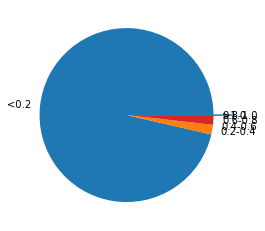

In [17]:
draw_epsilon(X_pred)

6. 绘制相对误差

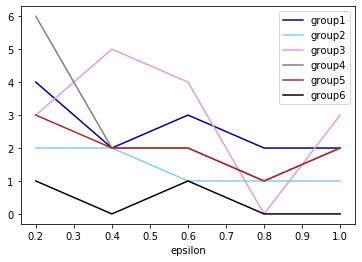

In [18]:
# 各组相对误差对比
e1=[4,2,3,2,2]
e2=[2,2,1,1,1]
e3=[3,5,4,0,3]
e4=[6,2,2,1,2]
e5=[3,2,2,1,2]
e6=[1,0,1,0,0]
i=[0.2,0.4,0.6,0.8,1.0]
plt.plot(i,e1,color='darkblue',label='group1')
plt.plot(i,e2,color='skyblue',label='group2')
plt.plot(i,e3,color='plum',label='group3')
plt.plot(i,e4,color='gray',label='group4')
plt.plot(i,e5,color='brown',label='group5')
plt.plot(i,e6,color='black',label='group6')
plt.legend()
plt.xlabel('epsilon')
plt.show()

In [274]:
#KSP 测试代码
test=nx.Graph()
for i in range(6):
    test.add_node(i)
test.add_edges_from([(0,1),(0,2),(2,1),(1,3),(2,3),(3,4),(2,4),(3,5),(4,5)])
test[0][1]['weight']=3
test[0][2]['weight']=2
test[2][1]['weight']=1
test[1][3]['weight']=4
test[2][3]['weight']=2
test[2][4]['weight']=3
test[3][4]['weight']=2
test[3][5]['weight']=1
test[4][5]['weight']=2
ksp(test,0,5,11)

candidate path [0, 1, 2, 3, 5]
candidate path [0, 2, 4, 5]
candidate path [0, 2, 3, 4, 5]
candidate path [0, 1, 3, 5]
candidate path [0, 2, 1, 3, 5]
candidate path [0, 2, 4, 3, 5]
candidate path [0, 1, 2, 4, 5]
candidate path [0, 1, 2, 3, 4, 5]
candidate path [0, 1, 3, 2, 4, 5]
only have 10 path


([5, 7, 7, 8, 8, 8, 8, 9, 10, 14],
 [[0, 2, 3, 5],
  [0, 1, 2, 3, 5],
  [0, 2, 4, 5],
  [0, 2, 3, 4, 5],
  [0, 1, 3, 5],
  [0, 2, 1, 3, 5],
  [0, 2, 4, 3, 5],
  [0, 1, 2, 4, 5],
  [0, 1, 2, 3, 4, 5],
  [0, 1, 3, 2, 4, 5]])